# PostSelecttML: Modeling Notebook Locally Run Modeling
### by Dolci Key 

 In following this notebook, I will run the current best model locally. 

## Import Libraries

In [8]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline 


import tensorflow as tf
from tensorflow import keras
from keras import layers, models, optimizers, metrics
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.metrics import Accuracy, Recall
from tensorflow.keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model
from sklearn.utils import class_weight

import os
import shutil
import random
import gc

from PIL import Image
import pydot
import graphviz

import pickle
from timeit import default_timer as timer

## Setting up the Training, Validation, and Test sets
## ONLY RUN THIS CODE ONE TIME. 

Here we are test train splitting the labeled data. 

In [10]:
# Creating Train / Val / Test folders (One time use only, otherwise you'll keep making copies)
#root_dir = '/Volumes/DOLCI KEY 2019/Neural Network/compressed/PHOTOS'
#classes_dir = ['/select', '/reject']

#val_ratio = 0.25 # 25% of the data in validation
#test_ratio = 0.05 # 5% of the data for the hold out set

#for cls in classes_dir:
#    os.makedirs(root_dir +'/train' + cls)
#    os.makedirs(root_dir +'/val' + cls)
#    os.makedirs(root_dir +'/test' + cls)


    # Randomly shuffle and separate the data 
#    src = root_dir + cls # Folder to copy images from

#    allFileNames = os.listdir(src)
#    np.random.shuffle(allFileNames)
#    train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
#                                                              [int(len(allFileNames)* (1 - val_ratio + test_ratio)), 
#                                                               int(len(allFileNames)* (1 - test_ratio))])
#
#    train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
#    val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]
#    test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

    # Copy-pasting images from original dir to the new ones
#    for name in train_FileNames:
#        shutil.copy(name, root_dir +'/train' + cls)

#    for name in val_FileNames:
#        shutil.copy(name, root_dir +'/val' + cls)

#    for name in test_FileNames:
#        shutil.copy(name, root_dir +'/test' + cls)

In [11]:
#print('Total images: ', len(allFileNames))
#print('Training: ', len(train_FileNames))
#print('Validation: ', len(val_FileNames))
#print('Testing: ', len(test_FileNames))

Total images:  2852
Training:  2281
Validation:  428
Testing:  143


## Creating Directories
Now that the data is split, here we point to the directories we want to use and set them up for modeling using ImageDataGenerator

In [24]:
# Training Set
train_dir = '/Volumes/DOLCI KEY 2019/Neural Network/compressed/PHOTOS/train'
train_set = image.ImageDataGenerator(rescale = 1/255, horizontal_flip = True, zoom_range = .3).flow_from_directory(train_dir,
                                                                  shuffle = True,
                                                                  target_size = (500,333), 
                                                                  color_mode='rgb',
                                                                  class_mode = 'binary')



Found 2736 images belonging to 2 classes.


In [25]:
# Validation Set
validation_dir = '/Volumes/DOLCI KEY 2019/Neural Network/compressed/PHOTOS/val'
validation_set = image.ImageDataGenerator(rescale = 1/255).flow_from_directory(validation_dir,
                                                                shuffle= False,
                                                                target_size = (500,333), 
                                                                color_mode='rgb',
                                                                class_mode='binary')

Found 513 images belonging to 2 classes.


In [26]:
# Test Set; This is a hold out set                                                 
test_dir = '/Volumes/DOLCI KEY 2019/Neural Network/compressed/PHOTOS/test'
test_set = image.ImageDataGenerator(rescale = 1/255).flow_from_directory(test_dir,
                                                                shuffle = False, 
                                                                target_size = (500,333), 
                                                                color_mode='rgb',
                                                                class_mode='binary')

Found 172 images belonging to 2 classes.


## Vanilla Model 

First, I will run a very simple model to get an idea of a baseline, or a starting point to really work from. The metrics I am most interested in is recall as I would much rather get a bad photo mixed in with the good ones occasionally, rather than a good one tossed out with the bad. 

In [17]:
# Vanilla model 

HEIGHT = 500
WIDTH = 333
DEPTH = 3

model = models.Sequential()
model.add(layers.Conv2D(32, 3, activation = 'relu', padding = 'same', input_shape=(HEIGHT, WIDTH, DEPTH)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [18]:
    model.compile(loss='binary_crossentropy',  
                optimizer=optimizers.RMSprop(lr=.0001),
                metrics = ['binary_accuracy', 'Recall', 'Precision'])

In [19]:
# Start timer to keep track of how long model is running for, not using class weights for this model
start = timer()

vanilla = model.fit(train_set, epochs = 5,
                            validation_data = validation_set)
end = timer()

# Take difference of time 
elapsed = end - start
print('Total Time Elapsed: ', int(elapsed//60), ' minutes ', (round(elapsed%60)), ' seconds')

Epoch 1/5
86/86 [==============================] - 496s 6s/step - loss: 3.2344 - binary_accuracy: 0.7281 - recall: 0.1978 - precision: 0.1919 - val_loss: 1.3848 - val_binary_accuracy: 0.8343 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/5
86/86 [==============================] - 397s 5s/step - loss: 1.4165 - binary_accuracy: 0.7259 - recall: 0.1890 - precision: 0.1842 - val_loss: 1.6304 - val_binary_accuracy: 0.8343 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/5
86/86 [==============================] - 463s 5s/step - loss: 0.7773 - binary_accuracy: 0.7694 - recall: 0.1165 - precision: 0.1879 - val_loss: 0.4565 - val_binary_accuracy: 0.8207 - val_recall: 0.0471 - val_precision: 0.2667
Epoch 4/5
86/86 [==============================] - 384s 4s/step - loss: 0.6265 - binary_accuracy: 0.7741 - recall: 0.0967 - precision: 0.1753 - val_loss: 0.4454 - val_binary_accuracy: 0.8246 - val_recall: 0.0471 - val_precision: 0.3077
Epoch 5/5
86/86 [=======================

## Model Summary, Evaluation, and Prediction on Unseen Data

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 500, 333, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 250, 166, 32)      0         
_________________________________________________________________
flatten (Flatten)            (None, 1328000)           0         
_________________________________________________________________
dense (Dense)                (None, 128)               169984128 
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 169,985,153
Trainable params: 169,985,153
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.evaluate(test_set)

6/6 [==============================] - 4s 720ms/step - loss: 0.5577 - binary_accuracy: 0.8314 - recall: 0.0000e+00 - precision: 0.0000e+00


[0.557681143283844, 0.8313953280448914, 0.0, 0.0]

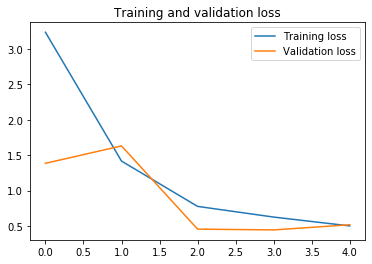

In [22]:
model_ = vanilla.history
epochs = vanilla.epoch
    
plt.figure()
plt.plot(epochs, model_['loss'], label='Training loss')
plt.plot(epochs, model_['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
    
plt.show();

In [23]:
model.save('MODELS/vanilla\assets')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: MODELS/vanillassets/assets


## Vanilla Model with Class Weights 

So now that I have an idea, let's see if weighting the classes helps with the scores. 

### Weighting the classes 
For later usage, we will weight the classes to help with class imbalance. 

In [29]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced', [0, 1], train_set.classes)
weights = dict(zip([0, 1], weights))
weights

{0: 0.5997369574747917, 1: 3.0065934065934066}

In [30]:
model = models.Sequential()
model.add(layers.Conv2D(32, 3, activation = 'relu', padding = 'same', input_shape=(HEIGHT, WIDTH, DEPTH)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [35]:
model.compile(loss ='binary_crossentropy',  
                optimizer = optimizers.RMSprop(lr = 0.0001), 
                weighted_metrics = 'Recall',
                metrics = 'binary_accuracy')

In [36]:
# Start timer to keep track of how long model is running for, not using class weights for this model
start = timer()

weighted_vanilla = model.fit(train_set, epochs = 5, class_weight = weights,
                            validation_data = validation_set)
end = timer()

# Take difference of time 
elapsed = end - start
print('Total Time Elapsed: ', int(elapsed//60), ' minutes ', (round(elapsed%60)), ' seconds')

Epoch 1/5
86/86 [==============================] - 399s 5s/step - loss: 6.1966 - binary_accuracy: 0.5252 - recall: 0.5143 - val_loss: 1.7663 - val_binary_accuracy: 0.4250 - val_recall: 0.8353
Epoch 2/5
86/86 [==============================] - 413s 5s/step - loss: 2.4849 - binary_accuracy: 0.5238 - recall: 0.4989 - val_loss: 4.9724 - val_binary_accuracy: 0.1813 - val_recall: 1.0000
Epoch 3/5
86/86 [==============================] - 501s 6s/step - loss: 1.2349 - binary_accuracy: 0.5599 - recall: 0.5407 - val_loss: 0.5386 - val_binary_accuracy: 0.7446 - val_recall: 0.2941
Epoch 4/5
86/86 [==============================] - 417s 5s/step - loss: 0.7871 - binary_accuracy: 0.6140 - recall: 0.5604 - val_loss: 0.4937 - val_binary_accuracy: 0.7914 - val_recall: 0.1294
Epoch 5/5
86/86 [==============================] - 418s 5s/step - loss: 0.6877 - binary_accuracy: 0.6466 - recall: 0.5736 - val_loss: 0.6148 - val_binary_accuracy: 0.6725 - val_recall: 0.5059
Total Time Elapsed:  36  minutes  28  se

## Model Summary, Evaluation, and Prediction on Unseen Data

In [37]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 500, 333, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 250, 166, 32)      0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1328000)           0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               169984128 
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 169,985,153
Trainable params: 169,985,153
Non-trainable params: 0
_________________________________________________________________


In [38]:
model.evaluate(test_set)

6/6 [==============================] - 4s 643ms/step - loss: 0.6465 - binary_accuracy: 0.6628 - recall: 0.4828


[0.6464608907699585, 0.6627907156944275, 0.48275861144065857]

In [39]:
model.save('MODELS/weighted_vanilla\assets')

INFO:tensorflow:Assets written to: MODELS/weighted_vanillassets/assets


## Iterative Modeling

In [40]:
HEIGHT = 500
WIDTH = 333
DEPTH = 3

model = models.Sequential()

model.add(layers.Conv2D(32, 3, activation = 'relu', input_shape=(HEIGHT, WIDTH, DEPTH)))
model.add(layers.MaxPooling2D())

model.add(layers.Conv2D(32, kernel_size=(3, 3), activation="relu"))
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"))
model.add(layers.MaxPooling2D())

model.add(layers.Conv2D(64, kernel_size=(3, 3), activation="relu"))
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(128, kernel_size=(3, 3), activation="sigmoid", padding="same"))
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(256, kernel_size=(3, 3), activation="sigmoid", padding="same"))
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())

model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(256, activation="sigmoid"))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1, activation="sigmoid"))

In [41]:
model.compile(loss='binary_crossentropy',  
                optimizer=optimizers.RMSprop(lr= 0.0001),
                metrics = ['accuracy', 'binary_accuracy', 'Recall'])

In [42]:
# Start timer to keep track of how long model is running for
start = timer()

model_script = model.fit(train_set, epochs = 10, class_weight = weights,
                            validation_data = validation_set)
end = timer()

# Take difference of time 
elapsed = end - start
print('Total Time Elapsed: ', int(elapsed//60), ' minutes ', (round(elapsed%60)), ' seconds')

Epoch 1/10
86/86 [==============================] - 462s 5s/step - loss: 0.7372 - accuracy: 0.4923 - binary_accuracy: 0.4923 - recall: 0.5011 - val_loss: 0.5939 - val_accuracy: 0.8343 - val_binary_accuracy: 0.8343 - val_recall: 0.0000e+00
Epoch 2/10
86/86 [==============================] - 446s 5s/step - loss: 0.7172 - accuracy: 0.5183 - binary_accuracy: 0.5183 - recall: 0.5055 - val_loss: 0.7188 - val_accuracy: 0.1657 - val_binary_accuracy: 0.1657 - val_recall: 1.0000
Epoch 3/10
86/86 [==============================] - 481s 6s/step - loss: 0.7224 - accuracy: 0.5186 - binary_accuracy: 0.5186 - recall: 0.4945 - val_loss: 0.7446 - val_accuracy: 0.1657 - val_binary_accuracy: 0.1657 - val_recall: 1.0000
Epoch 4/10
86/86 [==============================] - 658s 8s/step - loss: 0.7202 - accuracy: 0.5146 - binary_accuracy: 0.5146 - recall: 0.4923 - val_loss: 0.7287 - val_accuracy: 0.1657 - val_binary_accuracy: 0.1657 - val_recall: 1.0000
Epoch 5/10
86/86 [==============================] - 523s

## Model Summary, Evaluation, and Prediction on Unseen Data

In [43]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 498, 331, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 249, 165, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 247, 163, 32)      9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 123, 81, 32)       0         
_________________________________________________________________
dropout (Dropout)            (None, 123, 81, 32)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 123, 81, 64)       18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 61, 40, 64)       

In [44]:
model.evaluate(test_set)

6/6 [==============================] - 6s 937ms/step - loss: 0.7733 - accuracy: 0.1686 - binary_accuracy: 0.1686 - recall: 1.0000    


[0.7733196020126343, 0.16860465705394745, 0.16860465705394745, 1.0]

In [45]:
model.predict(test_set)

array([[0.5681052 ],
       [0.5680059 ],
       [0.56244075],
       [0.56611454],
       [0.5641559 ],
       [0.565399  ],
       [0.5527726 ],
       [0.5516333 ],
       [0.55561984],
       [0.57011056],
       [0.5704199 ],
       [0.56423   ],
       [0.57001346],
       [0.55127585],
       [0.54913974],
       [0.5471627 ],
       [0.54810274],
       [0.5690353 ],
       [0.546383  ],
       [0.55602515],
       [0.56006557],
       [0.56423783],
       [0.56478316],
       [0.56099606],
       [0.5431188 ],
       [0.56237817],
       [0.5532913 ],
       [0.5567089 ],
       [0.555997  ],
       [0.55642813],
       [0.5585128 ],
       [0.5612901 ],
       [0.55769   ],
       [0.5604487 ],
       [0.5525145 ],
       [0.5536995 ],
       [0.5686568 ],
       [0.555365  ],
       [0.5589398 ],
       [0.55543065],
       [0.5530562 ],
       [0.5547894 ],
       [0.55614537],
       [0.53725314],
       [0.5414689 ],
       [0.55364496],
       [0.55379844],
       [0.553

In [46]:
model.save('MODELS/model_script\assets')

INFO:tensorflow:Assets written to: MODELS/model_scriptssets/assets


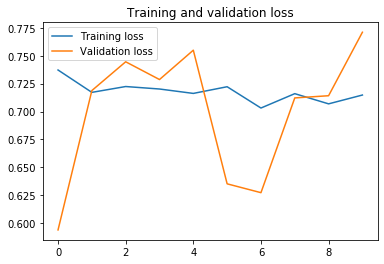

In [47]:
model_ = model_script.history
epochs = model_script.epoch
    
plt.figure()
plt.plot(epochs, model_['loss'], label='Training loss')
plt.plot(epochs, model_['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
    
plt.show();

## Testing Unseen Data

As we can see here, I have a lot of work left to do. 
The model rejects most images with around a .45 to .46 probability of being selected. 


reject image:  [[0.57376707]]


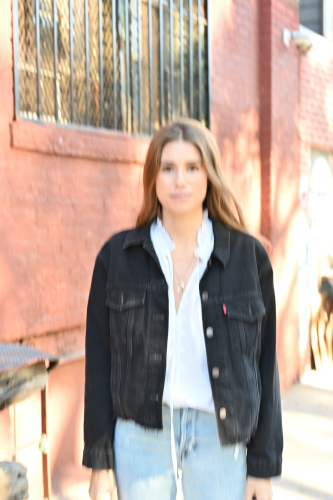

In [52]:
img_dir = 'THREE/DKP_3869_00015.jpg'
image = tf.keras.preprocessing.image.load_img(img_dir)
input_arr = keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])
predictions = model.predict(input_arr)
predictions

print ('reject image: ', predictions)
image

reject image:  [[0.57512397]]


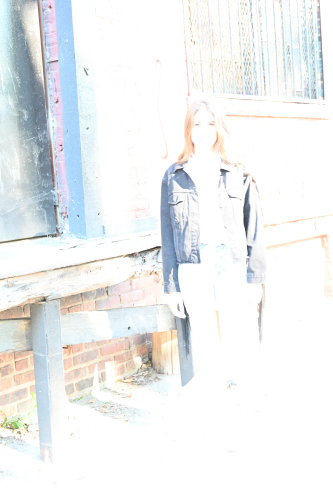

In [49]:
img_dir = 'THREE/DKP_3894_00033.jpg'
image = tf.keras.preprocessing.image.load_img(img_dir)
input_arr = keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])
predictions = model.predict(input_arr)
predictions

print ('reject image: ', predictions)
image

select image:  [[0.57360774]]


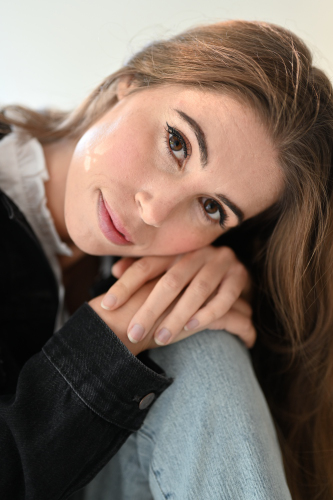

In [50]:
img_dir = 'THREE/DKP_4061_00073.jpg'
image = tf.keras.preprocessing.image.load_img(img_dir)
input_arr = keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])
predictions = model.predict(input_arr)


print ('select image: ', predictions)
image

In [51]:
model.predict(validation_set)

array([[0.56815875],
       [0.5688847 ],
       [0.5678739 ],
       [0.563715  ],
       [0.5626775 ],
       [0.56675667],
       [0.5650757 ],
       [0.5650111 ],
       [0.56637836],
       [0.56547683],
       [0.5679616 ],
       [0.5680963 ],
       [0.5659739 ],
       [0.5659741 ],
       [0.56406724],
       [0.5660018 ],
       [0.5596378 ],
       [0.5641897 ],
       [0.5659995 ],
       [0.5653895 ],
       [0.5653891 ],
       [0.5656859 ],
       [0.56566215],
       [0.5668947 ],
       [0.5672015 ],
       [0.5664205 ],
       [0.5639683 ],
       [0.56736284],
       [0.5528217 ],
       [0.5516725 ],
       [0.5522914 ],
       [0.5546801 ],
       [0.5524339 ],
       [0.5516191 ],
       [0.5532626 ],
       [0.55290186],
       [0.547548  ],
       [0.55121124],
       [0.5517925 ],
       [0.5576231 ],
       [0.5561641 ],
       [0.5569308 ],
       [0.5550554 ],
       [0.55496144],
       [0.556146  ],
       [0.56041896],
       [0.556697  ],
       [0.526

select image:  [[0.57410336]]


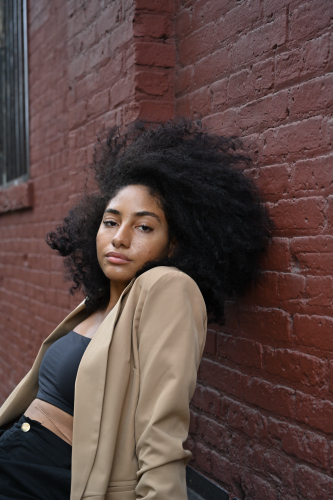

In [54]:
img_dir = 'THREE/select_2788_00076.jpg'
image = tf.keras.preprocessing.image.load_img(img_dir)
input_arr = keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])
predictions = model.predict(input_arr)


print ('select image: ', predictions)
image